In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import optuna
import mlflow
from sklearn.model_selection import GridSearchCV
from pmdarima.arima import auto_arima
from keras.models import load_model
import joblib
from weatherapi import WeatherPoint
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import xgboost as xgb

### API training
#### This file is for requesting training for WEATHER api website


In [2]:

# # Configure API key authorization: ApiKeyAuth
# configuration = swagger_client.Configuration()
# configuration.api_key['key'] = 'YOUR_API_KEY'
# # Uncomment below to setup prefix (e.g. Bearer) for API key, if needed
# # configuration.api_key_prefix['key'] = 'Bearer'
# 
# # create an instance of the API class
# api_instance = swagger_client.APIsApi(swagger_client.ApiClient(configuration))
# q = 'Moscow' # Указываем название города Москва
# dt = '2024-04-18' # Указываем сегодняшнюю дату
# lang = 'ru' # Язык ответа - русский
# 
# try:
#     # Получаем текущую погоду
#     api_response = api_instance.current_weather(q, lang=lang)
#     pprint(api_response)
# except ApiException as e:
#     print("Exception when calling APIsApi->current_weather: %s\n" % e)

In [6]:

# Подставьте свой ключ API погоды
key = "ae03964b347b4881afe205155242404"

# Широта и долгота для Москвы
latitude = 55.7558
longitude = 37.6176

# Инициализация объекта WeatherPoint
point = WeatherPoint(latitude, longitude)

# Установка ключа для доступа к данным
point.set_key(key)

# Получение текущей погоды
point.get_current_weather()

# Доступ к конкретным данным о погоде
temperature_celsius = point.temp_c  # температура в градусах Цельсия
#wind_speed_kmh = point.wind_kmh  # скорость ветра в километрах в час
local_datetime = point.localtime  # локальное время запроса


In [7]:
temperature_celsius

12.0

In [8]:
local_datetime

'2024-04-25 23:56'

In [11]:

# Установка базового URL и ключа API
base_url = "http://api.weatherapi.com/v1"
api_key = "ae03964b347b4881afe205155242404"  # Замените YOUR_API_KEY на ваш ключ API

# Параметры запроса
params = {
    "key": api_key,
    "q": "Moscow"  # Название города, для которого мы хотим получить погоду
}

# Формирование запроса
response = requests.get(f"{base_url}/current.json", params=params)

# Проверка успешности запроса
if response.status_code == 200:
    # Получение данных о погоде из ответа
    weather_data = response.json()

    # Извлечение интересующих нас данных о погоде
    temperature_celsius = weather_data['current']['temp_c']  # Температура в градусах Цельсия
    wind_speed_kmh = weather_data['current']['wind_kph']  # Скорость ветра в километрах в час
    local_datetime = weather_data['location']['localtime']  # Локальное время запроса

    # Вывод данных о погоде
    print(f"Текущая температура в Москве: {temperature_celsius}°C")
    print(f"Скорость ветра в Москве: {wind_speed_kmh} км/ч")
    print(f"Локальное время: {local_datetime}")
else:
    print("Ошибка при выполнении запроса:")
    print(response.text)


Текущая температура в Москве: 2.0°C
Скорость ветра в Москве: 19.1 км/ч
Локальное время: 2024-05-10 0:04


In [12]:
response.json()


{'location': {'name': 'Moscow',
  'region': 'Moscow City',
  'country': 'Russia',
  'lat': 55.75,
  'lon': 37.62,
  'tz_id': 'Europe/Moscow',
  'localtime_epoch': 1715288656,
  'localtime': '2024-05-10 0:04'},
 'current': {'last_updated_epoch': 1715288400,
  'last_updated': '2024-05-10 00:00',
  'temp_c': 2.0,
  'temp_f': 35.6,
  'is_day': 0,
  'condition': {'text': 'Clear',
   'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png',
   'code': 1000},
  'wind_mph': 11.9,
  'wind_kph': 19.1,
  'wind_degree': 240,
  'wind_dir': 'WSW',
  'pressure_mb': 1014.0,
  'pressure_in': 29.94,
  'precip_mm': 0.0,
  'precip_in': 0.0,
  'humidity': 55,
  'cloud': 0,
  'feelslike_c': -1.8,
  'feelslike_f': 28.8,
  'vis_km': 10.0,
  'vis_miles': 6.0,
  'uv': 1.0,
  'gust_mph': 15.0,
  'gust_kph': 24.1}}

In [17]:
api_response = response.json()
new_row = pd.DataFrame.from_dict({
    'Location': [api_response['location']['name']],
    'Region': [api_response['location']['region']],
    'Country': [api_response['location']['country']],
    'Latitude': [api_response['location']['lat']],
    'Longitude': [api_response['location']['lon']],
    'Localtime': [api_response['location']['localtime']],
    'Temperature_C': [api_response['current']['temp_c']],
    #'Temperature_F': [api_response['current']['temp_f']],
    'Wind_Speed_kph': [api_response['current']['wind_kph']],
    'Wind_Direction': [api_response['current']['wind_dir']],
    'Pressure_mb': [api_response['current']['pressure_mb']],
    'Humidity': [api_response['current']['humidity']],
    'Cloud': [api_response['current']['cloud']],
    'FeelsLike_C': [api_response['current']['feelslike_c']],
    #'FeelsLike_F': [api_response['current']['feelslike_f']],
    'Visibility_km': [api_response['current']['vis_km']],
    'UV_Index': [api_response['current']['uv']]
})

In [18]:
new_row

,Location,Region,Country,Latitude,Longitude,Localtime,Temperature_C,Wind_Speed_kph,Wind_Direction,Pressure_mb,Humidity,Cloud,FeelsLike_C,Visibility_km,UV_Index
0,Moscow,Moscow City,Russia,55.75,37.62,2024-05-10 0:04,2.0,19.1,WSW,1014.0,55,0,-1.8,10.0,1.0


In [19]:
new_row.columns

Index(['Location', 'Region', 'Country', 'Latitude', 'Longitude', 'Localtime',
       'Temperature_C', 'Wind_Speed_kph', 'Wind_Direction', 'Pressure_mb',
       'Humidity', 'Cloud', 'FeelsLike_C', 'Visibility_km', 'UV_Index'],
      dtype='object')

1 mb = 0.75006156 Po

In [34]:
data_raw = pd.read_excel('data/archive.xlsx')
data_raw

,Local time in Moscow,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,25.04.2024 21:00,14.9,744.0,757.3,0.9,69.0,"Calm, no wind",0.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.","Cirrus fibratus, sometimes uncinus, not progressively invading the sky.",20,9.2,No precipitation,12.0,NaN,NaN,NaN,NaN
1,25.04.2024 18:00,20.6,743.1,756.1,0.2,46.0,Wind blowing from the south-southeast,1.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.","Cirrus fibratus, sometimes uncinus, not progressively invading the sky.",20,8.6,No precipitation,12.0,NaN,NaN,NaN,NaN
2,25.04.2024 15:00,20.2,742.9,755.8,0.1,53.0,Wind blowing from the south-east,2.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.","Cirrus fibratus, sometimes uncinus, not progressively invading the sky.",20,10.2,NaN,NaN,NaN,NaN,NaN,NaN
3,25.04.2024 12:00,18.1,742.8,755.8,0.1,55.0,Wind blowing from the south-southeast,2.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.",Cirrostratus covering the whole sky.,19,8.9,NaN,NaN,NaN,NaN,NaN,NaN
4,25.04.2024 09:00,14.1,742.7,756.1,-1.1,58.0,Wind blowing from the south-southeast,3.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.","Cirrus (often in bands) and Cirrostratus, or Cirrostratus alone, progressively invading the sky; they generally thicken as a whole; the continuous veil extends more than 45 degrees above the horizon, without the sky being totally covered.",20,5.8,0.1,12.0,Surface of ground wet (standing water in small or large pools on surface).,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65505,01.02.2005 15:00,-6.6,746.8,761.8,NaN,83.0,Wind blowing from the south-east,3.0,NaN,NaN,...,Altocumulus castellanus or floccus.,"Cirrocumulus alone, or Cirrocumulus accompanied by Cirrus or Cirrostratus or both, but Cirrocumulus is predominant.",4,-9.0,NaN,NaN,NaN,NaN,NaN,NaN
65506,01.02.2005 12:00,-7.1,745.0,760.0,NaN,85.0,Wind blowing from the south-east,3.0,NaN,NaN,...,NaN,NaN,10,-9.2,NaN,NaN,NaN,NaN,NaN,NaN
65507,01.02.2005 09:00,-8.6,743.5,758.6,NaN,89.0,Wind blowing from the south-east,3.0,NaN,NaN,...,Altostratus translucidus.,"Cirrocumulus alone, or Cirrocumulus accompanied by Cirrus or Cirrostratus or both, but Cirrocumulus is predominant.",4,-10.1,3,12.0,NaN,NaN,Even layer of loose dry snow covering ground completely.,43
65508,01.02.2005 06:00,-8.2,742.8,757.9,NaN,90.0,Wind blowing from the south-east,3.0,NaN,NaN,...,Altostratus translucidus.,"Cirrocumulus alone, or Cirrocumulus accompanied by Cirrus or Cirrostratus or both, but Cirrocumulus is predominant.",NaN,-9.6,2,12.0,NaN,NaN,NaN,NaN


In [35]:
data_raw.to_csv('data/archive.csv', index=False)

#### archive data description
    T, air temperature (degrees Celsius) at 2 metre height above the earth's surface
    P0, atmospheric pressure at weather station level (millimeters of mercury)
    P, atmospheric pressure reduced to mean sea level (millimeters of mercury)
    U, relative humidity (%) at a height of 2 metres above the earth's surface
    DD, mean wind direction (compass points) at a height of 10-12 metres above the earth’s surface over the 10-minute period immediately preceding the observation
    FF, mean wind speed at a height of 10-12 metres above the earth’s surface over the 10-minute period immediately preceding the observation (meters per second)
    FF10, maximum gust value at a height of 10-12 metres above the earth’s surface over the 10-minute period immediately preceding the observation (meters per second)
    FF3, maximum gust value at a height of 10-12 metres above the earth’s surface between the periods of observations (meters per second)
    Tn, minimum air temperature (degrees Celsius) during the past period (not exceeding 12 hours)
    Tx, maximum air temperature (degrees Celsius) during the past period (not exceeding 12 hours)
    Nh, amount of all the CL cloud present or, if no CL cloud is present, the amount of all the CM cloud present
    H, height of the base of the lowest clouds (m)
    VV, horizontal visibility (km)
    RRR, amount of precipitation (millimeters)
    sss, snow depth (cm)



In [10]:
data = data_raw[['Local time in Moscow', 'T']]
data.dropna(inplace=True)

NameError: name 'data_raw' is not defined

C:\Users\Peter\AppData\Local\Temp\ipykernel_31580\4015242811.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')


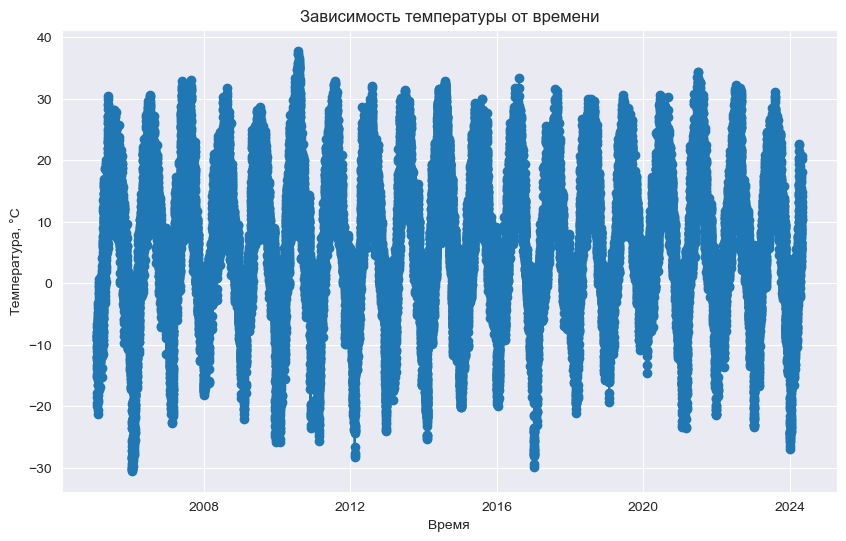

In [63]:




# Преобразование столбца 'Local time in Moscow' в формат datetime
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')

# Создание графика
plt.figure(figsize=(10, 6))
plt.plot(data['Local time in Moscow'], data['T'], marker='o', linestyle='-')

# Настройка осей и заголовка графика
plt.xlabel('Время')
plt.ylabel('Температура, °C')
plt.title('Зависимость температуры от времени')

# Вывод графика
plt.grid(True)
plt.show()


In [68]:
data.index

DatetimeIndex(['2024-04-25 21:00:00', '2024-04-25 18:00:00',
               '2024-04-25 15:00:00', '2024-04-25 12:00:00',
               '2024-04-25 09:00:00', '2024-04-25 06:00:00',
               '2024-04-25 03:00:00', '2024-04-25 00:00:00',
               '2024-04-24 21:00:00', '2024-04-24 18:00:00',
               ...
               '2005-02-02 06:00:00', '2005-02-02 03:00:00',
               '2005-02-02 00:00:00', '2005-02-01 21:00:00',
               '2005-02-01 18:00:00', '2005-02-01 15:00:00',
               '2005-02-01 12:00:00', '2005-02-01 09:00:00',
               '2005-02-01 06:00:00', '2005-02-01 03:00:00'],
              dtype='datetime64[ns]', name='Local time in Moscow', length=65503, freq=None)

In [18]:


# Load data
data = pd.read_excel('data/archive.xls')


# Preprocess data
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)
data = data.loc[:, ['T']]
data.dropna(inplace=True)
data['T'] = data['T'].astype('int32')



# # Select target variable
# endog_column = 'T'
# endog = data[endog_column]

#Split data into train and test sets
# train = endog.loc[endog.index < '2023-01-01']
# test = endog.loc[endog.index >= '2023-01-01']
train = data.loc[data.index < '2023-01-01']
test = data.loc[data.index >= '2023-01-01']

# # Define SARIMAX model parameters (order and seasonal_order)
# order = (1, 2, 1)
# seasonal_order = (1, 1, 1, 12)
# Подбор оптимальной SARIMA модели
model = auto_arima(train, seasonal=True, m=12)

# Прогнозирование с использованием SARIMA модели
forecast = model.predict(n_periods=len(test))

# Оценка производительности модели
mse = mean_squared_error(test, forecast)
print('Mean Squared Error:', mse)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Фактическая температура')
plt.plot(test.index, forecast, color='red', label='Прогноз температуры')
plt.title('Прогноз температуры с использованием SARIMA (с автоподбором гиперпараметров)')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()


MemoryError: Unable to allocate 120. MiB for an array with shape (16, 16, 61655) and data type float64

In [ ]:


# Fit auto_arima model
model = auto_arima(train, seasonal=True, m=12)

# Save the model to a file
with open('auto_arima_model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [54]:

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                52408
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -99960.167
Date:                            Fri, 26 Apr 2024   AIC                         199930.334
Time:                                    01:57:09   BIC                         199974.666
Sample:                                         0   HQIC                        199944.190
                                          - 52408                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1503      0.015     -9.773      0.000      -0.180      -0.120
ma.L1          0.3366      0.015   

### KERAS

Epoch 1/100
2047/2047 [==============================] - 29s 12ms/step - loss: 0.0030
Epoch 2/100
2047/2047 [==============================] - 24s 12ms/step - loss: 6.4454e-04
Epoch 3/100
2047/2047 [==============================] - 24s 12ms/step - loss: 6.0209e-04
Epoch 4/100
2047/2047 [==============================] - 24s 12ms/step - loss: 5.6295e-04
Epoch 5/100
2047/2047 [==============================] - 24s 12ms/step - loss: 5.4022e-04
Epoch 6/100
2047/2047 [==============================] - 24s 12ms/step - loss: 5.1258e-04
Epoch 7/100
2047/2047 [==============================] - 25s 12ms/step - loss: 5.0191e-04
Epoch 8/100
2047/2047 [==============================] - 25s 12ms/step - loss: 4.9800e-04
Epoch 9/100
2047/2047 [==============================] - 26s 13ms/step - loss: 4.9655e-04
Epoch 10/100
2047/2047 [==============================] - 27s 13ms/step - loss: 4.8484e-04
Epoch 11/100
2047/2047 [==============================] - 25s 12ms/step - loss: 4.8434e-04
Epoch 12/100

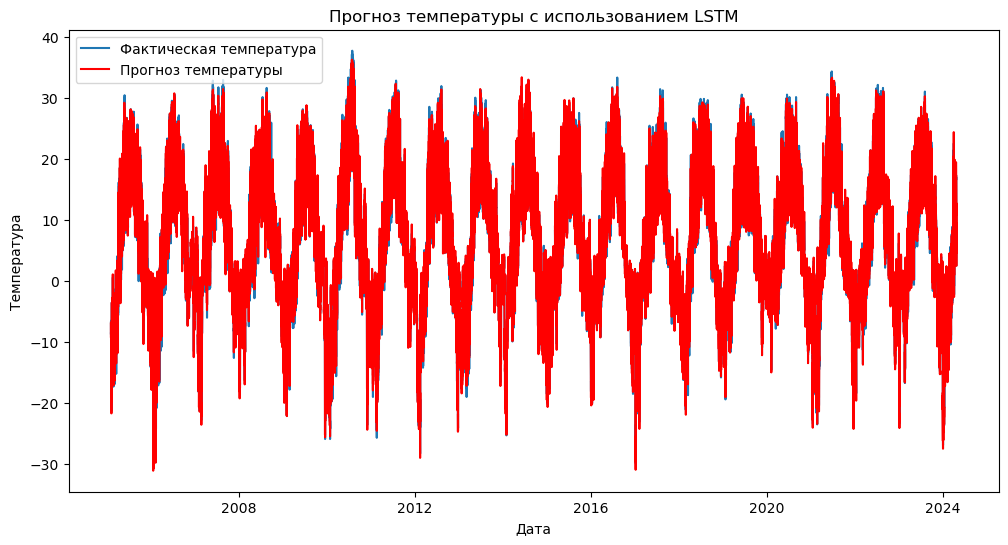

In [2]:


# Load data
data = pd.read_excel('data/archive.xls')

# Preprocess data
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)
data = data.loc[:, ['T']]
data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define function to create dataset
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps - 1):
        X.append(dataset[i:(i + time_steps), 0])
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

# Create train and test sets
time_steps = 12  # You can adjust this parameter
X_train, y_train = create_dataset(scaled_data, time_steps)
X_test, y_test = create_dataset(scaled_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate MSE
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

# Visualization of the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[time_steps+1:], data['T'][time_steps+1:], label='Фактическая температура')
plt.plot(data.index[time_steps+1:], test_predict, color='red', label='Прогноз температуры')
plt.title('Прогноз температуры с использованием LSTM')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()


In [3]:
#model.save("lstm_model.h5")


In [7]:

# Load the model
loaded_model = load_model("lstm_model.h5")

In [17]:
data = pd.read_excel('data/archive.xls')


# Preprocess data
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)
data = data.loc[:, ['T']]
data.dropna(inplace=True)
data['T'] = data['T'].astype('int32')
data

,T
Local time in Moscow,
2024-04-25 21:00:00,14
2024-04-25 18:00:00,20
2024-04-25 15:00:00,20
2024-04-25 12:00:00,18
2024-04-25 09:00:00,14
...,...
2005-02-01 15:00:00,-6
2005-02-01 12:00:00,-7
2005-02-01 09:00:00,-8


In [13]:
# Convert string timestamp to datetime object
timestamp = pd.to_datetime('2024-04-30 12:00:00')

# Preprocess the timestamp into a format suitable for input to the model
# For example, you might need to extract features from the timestamp or scale it
# In this example, let's assume you're using the timestamp directly as input
input_data = np.array([[timestamp.timestamp()]])  # Convert timestamp to Unix timestamp

# Make predictions using the loaded model
predictions = loaded_model.predict(input_data)

1/1 [==============================] - 1s 1s/step


In [14]:
predictions

array([[0.668957]], dtype=float32)

0:	learn: 10.6134455	total: 3.38ms	remaining: 3.38s
10:	learn: 9.1979698	total: 28.9ms	remaining: 2.6s
20:	learn: 8.3307693	total: 53.2ms	remaining: 2.48s
30:	learn: 7.2490426	total: 77.9ms	remaining: 2.44s
40:	learn: 6.5747699	total: 101ms	remaining: 2.37s
50:	learn: 6.1437091	total: 125ms	remaining: 2.32s
60:	learn: 5.6978780	total: 149ms	remaining: 2.29s
70:	learn: 5.4663780	total: 173ms	remaining: 2.26s
80:	learn: 5.3461913	total: 196ms	remaining: 2.22s
90:	learn: 5.1632817	total: 222ms	remaining: 2.21s
100:	learn: 5.0504958	total: 249ms	remaining: 2.22s
110:	learn: 4.9645805	total: 277ms	remaining: 2.22s
120:	learn: 4.9107953	total: 301ms	remaining: 2.18s
130:	learn: 4.8809595	total: 324ms	remaining: 2.15s
140:	learn: 4.8421269	total: 353ms	remaining: 2.15s
150:	learn: 4.8154456	total: 380ms	remaining: 2.14s
160:	learn: 4.7898387	total: 409ms	remaining: 2.13s
170:	learn: 4.7656930	total: 440ms	remaining: 2.13s
180:	learn: 4.7491090	total: 468ms	remaining: 2.12s
190:	learn: 4.73684

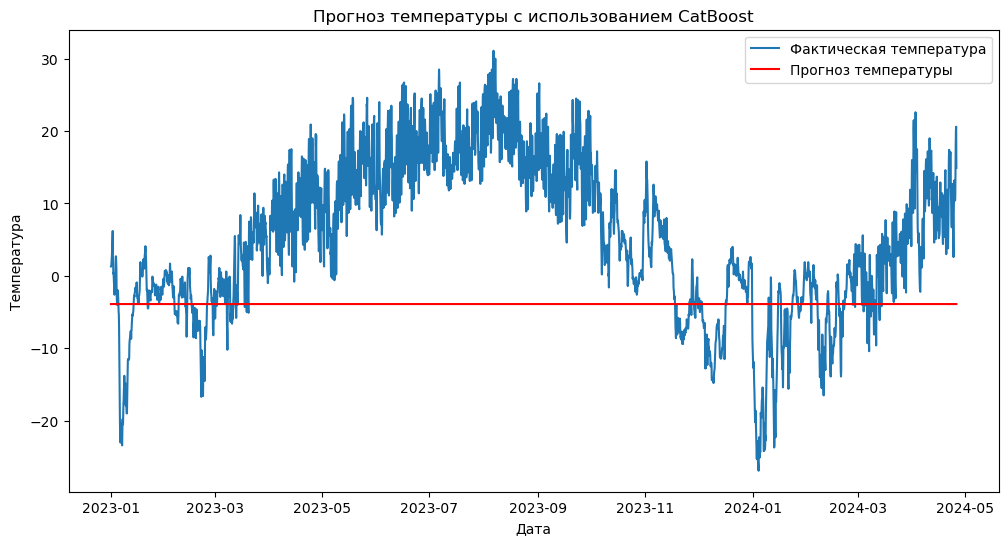

In [9]:

# Load data
data = pd.read_excel('data/archive.xls')

# Preprocess data
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)
data = data.loc[:, ['T']]
data.dropna(inplace=True)
data['T'] = data['T'].astype('float16')

# Split data into train and test sets
train = data.loc[data.index < '2023-01-01']
test = data.loc[data.index >= '2023-01-01']

# Define CatBoost model parameters
# model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6)
model = CatBoostRegressor(loss_function='RMSE', depth=3, learning_rate=0.4, iterations=1000,
                          random_seed=18,
                          od_type='Iter',
                          od_wait=20,)


# Fit CatBoost model
model.fit(train.index.values.reshape(-1, 1), train['T'].values, verbose=10)

# Save the trained CatBoost model
model.save_model('catboost_model')

# Forecast using CatBoost model
forecast = model.predict(test.index.values.reshape(-1, 1))

# Performance evaluation of the model
mse = mean_squared_error(test['T'].values, forecast)
print('Mean Squared Error:', mse)

# Visualization of the results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['T'], label='Фактическая температура')
plt.plot(test.index, forecast, color='red', label='Прогноз температуры')
plt.title('Прогноз температуры с использованием CatBoost')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()


*********

In [7]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt
# import mlflow
# 
# # Load data
# data = pd.read_excel('data/archive.xls')
# 
# # Preprocess data
# data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
# data.set_index('Local time in Moscow', inplace=True)
# data = data.loc[:, ['T']]
# data.dropna(inplace=True)
# data['T'] = data['T'].astype('float16')
# 
# # Split data into train and test sets
# train = data.loc[data.index < '2023-01-01']
# test = data.loc[data.index >= '2023-01-01']
# 
# # Start MLflow run
# with mlflow.start_run():
#     # Log parameters
#     mlflow.log_param("iterations", 100)
#     mlflow.log_param("learning_rate", 0.1)
#     mlflow.log_param("depth", 6)
# 
#     # Define CatBoost model parameters
#     model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6)
# 
#     # Fit CatBoost model and log progress
#     mlflow.log_metric("train_progress", 0)
#     model.fit(train.index.values.reshape(-1, 1), train['T'].values, verbose=10)
# 
#     # Log CatBoost model
#     mlflow.catboost.log_model(model, "catboost_model")
# 
#     # Forecast using CatBoost model
#     forecast = model.predict(test.index.values.reshape(-1, 1))
# 
#     # Performance evaluation of the model
#     mse = mean_squared_error(test['T'].values, forecast)
#     print('Mean Squared Error:', mse)
#     mlflow.log_metric("mse", mse)
# 
#     # Visualization of the results
#     plt.figure(figsize=(12, 6))
#     plt.plot(test.index, test['T'], label='Фактическая температура')
#     plt.plot(test.index, forecast, color='red', label='Прогноз температуры')
#     plt.title('Прогноз температуры с использованием CatBoost')
#     plt.xlabel('Дата')
#     plt.ylabel('Температура')
#     plt.legend()
#     plt.show()


0:	learn: 10.6825344	total: 151ms	remaining: 15s
10:	learn: 9.8128173	total: 186ms	remaining: 1.51s
20:	learn: 9.2589797	total: 222ms	remaining: 836ms
30:	learn: 8.8225305	total: 258ms	remaining: 574ms
40:	learn: 8.3572004	total: 295ms	remaining: 425ms
50:	learn: 7.7700012	total: 330ms	remaining: 317ms
60:	learn: 7.3058428	total: 368ms	remaining: 235ms
70:	learn: 6.9443029	total: 408ms	remaining: 167ms
80:	learn: 6.6468428	total: 450ms	remaining: 106ms
90:	learn: 6.3490818	total: 489ms	remaining: 48.4ms
99:	learn: 6.1879376	total: 528ms	remaining: 0us


MlflowException: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}

### Greedsearch

Mean Squared Error: 1867.827137108742


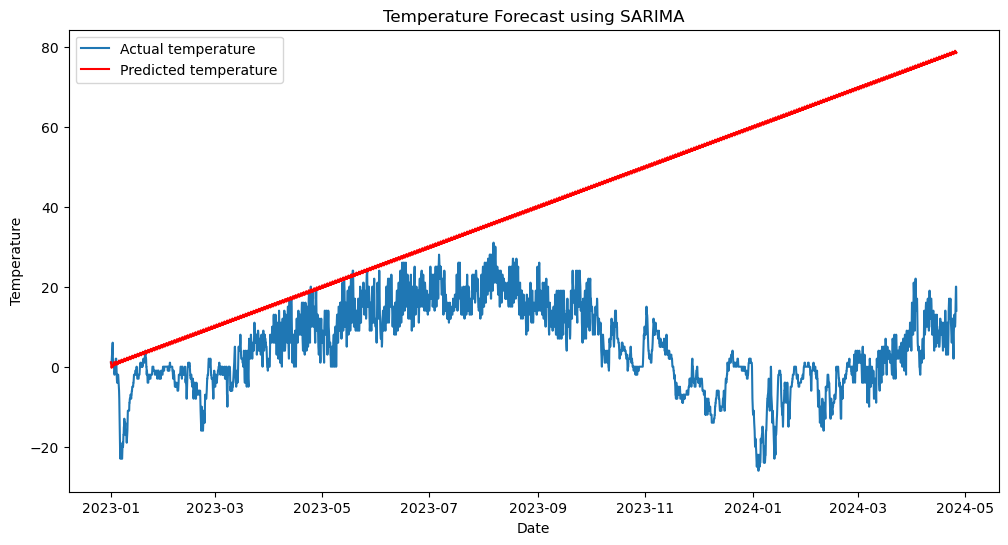

In [15]:


# Load data
data = pd.read_excel('data/archive.xls')

# Preprocess data
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)
data = data.loc[:, ['T']]
data.dropna(inplace=True)
data['T'] = data['T'].astype('int32')

# Resample data to 3-hour frequency
data = data.asfreq('3H')

# Split data into train and test sets
train = data.loc[data.index < '2023-01-01']
test = data.loc[data.index >= '2023-01-01']

# Define SARIMA model parameters
order = (1, 1, 1)  # Adjust order as needed
seasonal_order = (1, 1, 1, 12)

# Fit SARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_model = model.fit(disp=False)

# Make predictions
forecast = fit_model.forecast(steps=len(test))

# Calculate MSE
mse = mean_squared_error(test, forecast)
print('Mean Squared Error:', mse)

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual temperature')
plt.plot(test.index, forecast, color='red', label='Predicted temperature')
plt.title('Temperature Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


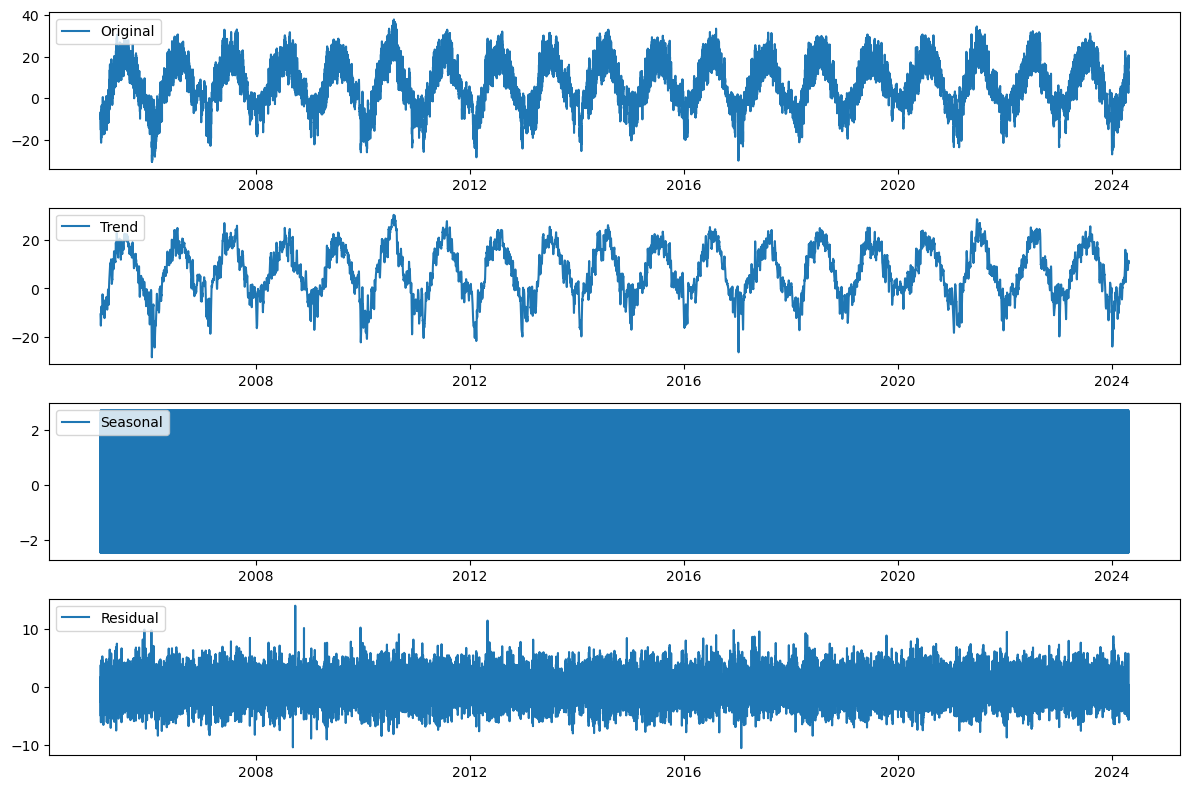

In [20]:


# Load and preprocess data
data = pd.read_excel('data/archive.xls')
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)
data = data.loc[:, ['T']]
data.dropna(inplace=True)

# Create a new index with the desired frequency
new_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='3H')

# Reindex the dataframe with the new index and fill missing values using interpolation
data = data.reindex(new_index)
data['T'] = data['T'].interpolate(method='linear')

# Perform seasonal decomposition
decomposition = seasonal_decompose(data['T'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(data.index, data['T'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/100
45850/45850 - 69s - loss: 0.0013 - 69s/epoch - 1ms/step
Epoch 2/100
45850/45850 - 66s - loss: 8.3775e-04 - 66s/epoch - 1ms/step
Epoch 3/100
45850/45850 - 72s - loss: 8.3632e-04 - 72s/epoch - 2ms/step
Epoch 4/100
45850/45850 - 72s - loss: 8.3503e-04 - 72s/epoch - 2ms/step
Epoch 5/100
45850/45850 - 69s - loss: 8.3467e-04 - 69s/epoch - 2ms/step
Epoch 6/100
45850/45850 - 75s - loss: 8.2995e-04 - 75s/epoch - 2ms/step
Epoch 7/100
45850/45850 - 74s - loss: 8.2822e-04 - 74s/epoch - 2ms/step
Epoch 8/100
45850/45850 - 67s - loss: 8.2485e-04 - 67s/epoch - 1ms/step
Epoch 9/100
45850/45850 - 70s - loss: 8.2607e-04 - 70s/epoch - 2ms/step
Epoch 10/100
45850/45850 - 67s - loss: 8.2619e-04 - 67s/epoch - 1ms/step
Epoch 11/100
45850/45850 - 66s - loss: 8.2458e-04 - 66s/epoch - 1ms/step
Epoch 12/100
45850/45850 - 66s - loss: 8.2218e-04 - 66s/epoch - 1ms/step
Epoch 13/100
45850/45850 - 66s - loss: 8.2145e-04 - 66s/epoch - 1ms/step
Epoch 14/100
45850/45850 - 66s - loss: 8.2100e-04 - 66s/epoch - 

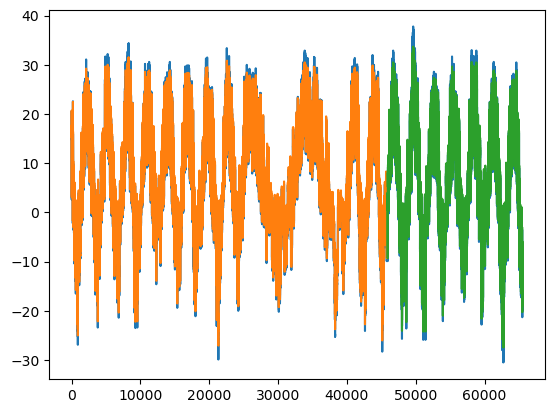

In [21]:


# Загрузка данных
data = pd.read_excel('data/archive.xls')

# Предобработка данных
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)
data = data.loc[:, ['T']]
data.dropna(inplace=True)
dataset = data.values.astype('float32')

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Функция для создания датасета для временных рядов
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Преобразование данных в формат, пригодный для обучения
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Изменение формы входных данных для LSTM [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Создание и компиляция модели LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Предсказание
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Инвертирование нормализации для получения исходных данных
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Расчет ошибки модели
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Визуализация результатов
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [22]:
model.save("model1.h5")


In [6]:

# Load the model
loaded_model = load_model("model1.h5")

In [7]:
input_date = np.array(['2024-05-25 21:00:00'], dtype='datetime64')


In [9]:
# Преобразование строки даты в формат datetime
input_date = pd.to_datetime('2024-06-25 21:00:00')

# Получение Unix timestamp
unix_timestamp = input_date.timestamp()

# Создание массива с одним значением Unix timestamp
input_data = np.array([unix_timestamp])

# Предсказание с использованием модели
input_data = input_data.reshape(-1, 1, 1)
predictions = loaded_model.predict(input_data)
predictions

1/1 [==============================] - 0s 21ms/step


array([[1.4014456]], dtype=float32)

In [56]:

# Базовая дата
base_date = datetime(1970, 1, 1)

# Преобразуйте строку с датой в формат datetime
target_date = '2023-06-23 21:00:00'
target_date = datetime.strptime(target_date, '%Y-%m-%d %H:%M:%S')

# Получите количество секунд с базовой даты
target_seconds = (target_date - base_date).total_seconds()

# Создайте массив с этим значением
target_data = np.array([[target_seconds]])

# Подготовьте данные, если необходимо (например, нормализация)
# ...

# Преобразуйте данные в формат, пригодный для LSTM
target_data = np.reshape(target_data, (target_data.shape[0], 1, target_data.shape[1]))

# Используйте обученную модель для предсказания температуры
prediction = loaded_model.predict(target_data)

# Декодируйте предсказанное значение обратно в исходный масштаб, если это необходимо
# ...

# Выведите предсказанное значение температуры
print('Predicted temperature:', prediction)


1/1 [==============================] - 0s 23ms/step
Predicted temperature: [[1.4014456]]


In [38]:
predictions

array([[1.4014456]], dtype=float32)

In [57]:
data.head()

,T
Local time in Moscow,
2024-04-25 21:00:00,14.9
2024-04-25 18:00:00,20.6
2024-04-25 15:00:00,20.2
2024-04-25 12:00:00,18.1
2024-04-25 09:00:00,14.1
